# Parallel solution of problem using substructuring and static condensation of internal nodes

Author(s): Jukka Aho <jukka.aho@kapsi.fi>

**Abstract**: First ideas of going towards parallel solution

## Substructuring and static condensation

Let us again consider something as simple as possible to give idea of algorithm, e.g. 1d poisson equation with homogeneous Dirichlet boundary condition and Neumann boundary condition in other end.

\begin{equation}
u'' = 0 \quad u(0)=0 \quad u'(2)=1
\end{equation}

Accurate solution is $u(x) = x$.

We discretize this to to elements and have three nodes therefore. Discretized solution is

In [15]:
A = [1 -1 0; -1 2 -1; 0 -1 1]
f = [0, 0, 1]
free_dofs = [2, 3]
u = zeros(3)
u[free_dofs] = A[free_dofs, free_dofs]\f[free_dofs]
u

3-element Array{Float64,1}:
 0.0
 1.0
 2.0

We call middle to node to interior node and left and right node to boundary nodes, i.e.

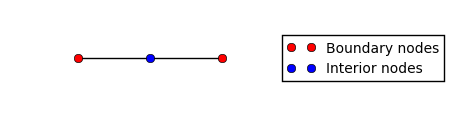

In [16]:
using PyPlot
figure(figsize=(5, 1))
plot([0, 1, 2], [0, 0, 0], "k")
plot([0, 2], [0, 0], "ro", label="Boundary nodes")
plot([1], [0], "bo", label="Interior nodes")
legend(loc=5, prop=Dict("size" => 10))
xlim(-0.2, 5.2)
axis("off");

Static condensation. We define two sets of nodes, $I$ for interior nodes and $B$ for boundary nodes, so the equation in block-matrix form is now

\begin{equation}
\mathbf{A}=\left[\begin{array}{cc}
\mathbf{A}_{\mathrm{II}} & \mathbf{A}_{\mathrm{IB}}\\
\mathbf{A}_{\mathrm{BI}} & \mathbf{A}_{\mathrm{BB}}
\end{array}\right]\quad\mathbf{u}=\left[\begin{array}{c}
\mathbf{u}_{\mathrm{I}}\\
\mathbf{u}_{\mathrm{B}}
\end{array}\right]\quad\mathbf{f}=\left[\begin{array}{c}
\mathbf{f}_{\mathbf{I}}\\
\mathbf{f}_{\mathbf{B}}
\end{array}\right]
\end{equation}

After matrix algebra we end up to

\begin{eqnarray}
\mathbf{A}_{\mathrm{II}}\mathbf{u}_{\mathrm{I}}+\mathbf{A}_{\mathrm{IB}}\mathbf{u}_{\mathrm{B}} & = & \mathbf{f}_{\mathbf{I}}\\
\mathbf{A}_{\mathrm{BI}}\mathbf{u}_{\mathrm{I}}+\mathbf{A}_{\mathrm{BB}}\mathbf{u}_{\mathrm{B}} & = & \mathbf{f}_{\mathbf{B}}
\end{eqnarray}

\begin{equation}
\mathbf{u}_{\mathrm{I}}=\mathbf{A}_{\mathrm{II}}^{-1}\left(\mathbf{f}_{\mathbf{I}}-\mathbf{A}_{\mathrm{IB}}\mathbf{u}_{\mathrm{B}}\right)
\end{equation}

\begin{equation}
\mathbf{A}_{\mathrm{BI}}\mathbf{u}_{\mathrm{I}}+\mathbf{A}_{\mathrm{BB}}\mathbf{u}_{\mathrm{B}}=\mathbf{A}_{\mathrm{BI}}\left(\mathbf{A}_{\mathrm{II}}^{-1}\left(\mathbf{f}_{\mathbf{I}}-\mathbf{A}_{\mathrm{IB}}\mathbf{u}_{\mathrm{B}}\right)\right)+\mathbf{A}_{\mathrm{BB}}\mathbf{u}_{\mathrm{B}}=\mathbf{f}_{\mathbf{B}}
\end{equation}

\begin{equation}
\mathbf{A}_{\mathrm{BI}}\left(\mathbf{A}_{\mathrm{II}}^{-1}\mathbf{f}_{\mathbf{I}}-\mathbf{A}_{\mathrm{II}}^{-1}\mathbf{A}_{\mathrm{IB}}\mathbf{u}_{\mathrm{B}}\right)+\mathbf{A}_{\mathrm{BB}}\mathbf{u}_{\mathrm{B}}=\mathbf{f}_{\mathbf{B}}
\end{equation}

\begin{equation}
\mathbf{A}_{\mathrm{BI}}\mathbf{A}_{\mathrm{II}}^{-1}\mathbf{f}_{\mathbf{I}}-\mathbf{A}_{\mathrm{BI}}\mathbf{A}_{\mathrm{II}}^{-1}\mathbf{A}_{\mathrm{IB}}\mathbf{u}_{\mathrm{B}}+\mathbf{A}_{\mathrm{BB}}\mathbf{u}_{\mathrm{B}}=\mathbf{f}_{\mathbf{B}}
\end{equation}

\begin{equation}
\mathbf{A}_{\mathrm{BB}}\mathbf{u}_{\mathrm{B}}-\mathbf{A}_{\mathrm{BI}}\mathbf{A}_{\mathrm{II}}^{-1}\mathbf{A}_{\mathrm{IB}}\mathbf{u}_{\mathrm{B}}=\mathbf{f}_{\mathbf{B}}-\mathbf{A}_{\mathrm{BI}}\mathbf{A}_{\mathrm{II}}^{-1}\mathbf{f}_{\mathbf{I}}
\end{equation}

\begin{equation}
\left(\mathbf{A}_{\mathrm{BB}}-\mathbf{A}_{\mathrm{BI}}\mathbf{A}_{\mathrm{II}}^{-1}\mathbf{A}_{\mathrm{IB}}\right)\mathbf{u}_{\mathrm{B}}=\mathbf{f}_{\mathbf{B}}-\mathbf{A}_{\mathrm{BI}}\mathbf{A}_{\mathrm{II}}^{-1}\mathbf{f}_{\mathbf{I}}
\end{equation}

\begin{equation}
\mathbf{A}_{\mathrm{C}}=\mathbf{f}_{\mathrm{C}}
\end{equation}

where interior nodes has been succesfully eliminated. So we first form condensated matrix $\mathbf{A}_{\mathrm{C}}$ and vector $\mathbf{f}_{\mathrm{C}}$

In [17]:
B = [1, 3]
I = [2]
Ac = A[B,B] - A[B,I]*inv(A[I,I])*A[I,B]
Ac

2x2 Array{Float64,2}:
  0.5  -0.5
 -0.5   0.5

In [18]:
fc = f[B] - A[B,I]*inv(A[I,I])*f[I]
fc

2-element Array{Float64,1}:
 0.0
 1.0

Next we solve the condensed system with interior node removed

In [19]:
free_dofsc = [2] # free degrees of freedom in condensed system
u = zeros(3)
u[B[free_dofsc]] = Ac[free_dofsc, free_dofsc]\fc[free_dofsc]
u

3-element Array{Float64,1}:
 0.0
 0.0
 2.0

If we want to calculate field variable in interior node:

In [20]:
u[I] = inv(A[I,I])*(f[I] - A[I,B]*u[B])
u

3-element Array{Float64,1}:
 0.0
 1.0
 2.0

Of course we cannot take inverse of interior node matrix in real life applications, it's costs way too much..

## Parallel solution

We can use exactly same concept as described earlier. We first remove interior nodes in subdomains and after that solve boundary system. Boundaries must be "tied" together with Lagrange multipliers, penalty method or something similar. This time we discretize the system to 4 elements and split it to two domains:

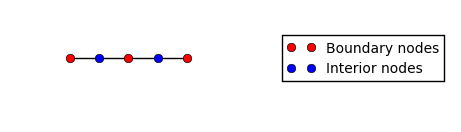

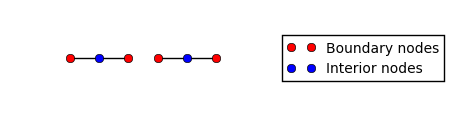

In [21]:
figure(figsize=(5, 1))
plot([0, 1, 2, 3, 4], [0, 0, 0, 0, 0], "k")
plot([0, 2, 4], [0, 0, 0], "ro", label="Boundary nodes")
plot([1, 3], [0, 0], "bo", label="Interior nodes")
legend(loc=5, prop=Dict("size" => 10))
xlim(-0.2, 13)
axis("off")
figure(figsize=(5, 1))
plot([0, 1, 2], [0, 0, 0], "k")
plot([3, 4, 5], [0, 0, 0], "k")

plot([0, 2, 3, 5], [0, 0, 0, 0], "ro", label="Boundary nodes")
plot([1, 4], [0, 0], "bo", label="Interior nodes")
legend(loc=5, prop=Dict("size" => 10))
xlim(-0.2, 13)
axis("off");

Here the third node in now shared between boundaries. Now we can make static condensation in parallel, because domains do not share information yet

In [22]:
"""
Condensate system A = f, i.e. remove interior nodes from system.
"""
function condensate(A, f, B, I)
    # in real life application we obviously make integration
    # and assembly of system here before condensation
    Ac = A[B,B] - A[B,I]*inv(A[I,I])*A[I,B]
    fc = f[B] - A[B,I]*inv(A[I,I])*f[I]
    return Ac, fc
end
A1 = 2*copy(A)
f1 = zeros(3)
A2 = 2*copy(A)
f2 = copy(f)

# PARALLEL solution starts here
Ac1, fc1 = condensate(A1, f1, B, I) # worker 1: assembly domain 1 matrices and make static condensation
Ac2, fc2 = condensate(A2, f2, B, I) # worker 2: assembly domain 2 matrices and make static condensation

(
2x2 Array{Float64,2}:
  1.0  -1.0
 -1.0   1.0,

[0.0,1.0])

Now we have two 2x2 systems describing the boundaries. In condensated system

\begin{eqnarray}
u_{1} & = & 0\\
u_{2} & = & u_{3}
\end{eqnarray}

So our Lagrange multipliers ("restriction operator"?) are

In [23]:
R = [1 0 0 0; 0 1 -1 0]

2x4 Array{Int64,2}:
 1  0   0  0
 0  1  -1  0

Assembly of boundary systems + Lagrange multipliers

In [24]:
Z22 = zeros(2, 2)
Z2 = zeros(2)
A_ass = [Ac1 Z22; Z22 Ac2]
f_ass = [fc1; fc2]

4-element Array{Float64,1}:
 0.0
 0.0
 0.0
 1.0

In [25]:
A_ass_w_lag = [A_ass R'; R Z22]
f_ass_w_lag = [f_ass; Z2]

6-element Array{Float64,1}:
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0

In [26]:
sol = A_ass_w_lag \ f_ass_w_lag

6-element Array{Float64,1}:
  0.0
  1.0
  1.0
  2.0
  1.0
 -1.0

Here we have our shared boundary node solution defined twice + Lagrange multipliers. I think we can go even further and condensate this remaining system. If we again are interested of interior solution in domains, we can

In [27]:
inv(A1[I,I])*(f1[I] - A1[I,B]*sol[[1, 2]])

1-element Array{Float64,1}:
 0.5

In [28]:
inv(A2[I,I])*(f2[I] - A2[I,B]*sol[[3, 4]])

1-element Array{Float64,1}:
 1.5